In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7)

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras.layers.advanced_activations as AdvA
from keras.utils import np_utils

In [2]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


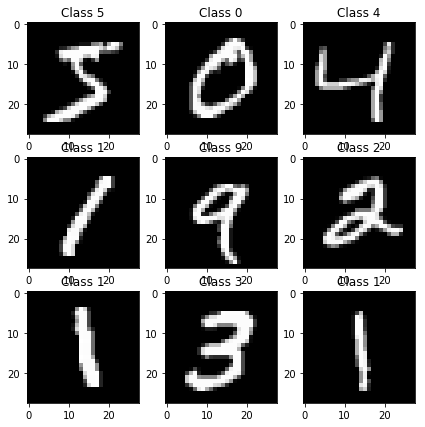

In [3]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))
    #plt.show()
plt.show()

In [4]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [5]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## original model and results 

In [6]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                 # ensures the output is a valid probaility distribution, that is
                                 # that its values are all non-negative and sum to 1.


In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
model.fit(X_train, Y_train,
          batch_size=128, nb_epoch=4,
            verbose=1,
          validation_data=(X_test, Y_test))

/home/udion/Misc/anaconda3/envs/DeepCV/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 13s 210us/step - loss: 0.2524 - acc: 0.9238 - val_loss: 0.1082 - val_acc: 0.9642
Epoch 2/4
60000/60000 [==============================] - 5s 88us/step - loss: 0.1024 - acc: 0.9686 - val_loss: 0.0787 - val_acc: 0.9743
Epoch 3/4
60000/60000 [==============================] - 5s 87us/step - loss: 0.0723 - acc: 0.9773 - val_loss: 0.0712 - val_acc: 0.9773
Epoch 4/4
60000/60000 [==============================] - 5s 86us/step - loss: 0.0550 - acc: 0.9826 - val_loss: 0.0695 - val_acc: 0.9783


In [12]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0695413226805
Test accuracy: 0.9783


## Altered model and the results : version 1

### motivation: recent research literatures have advocated in many different activation function other than relu(which is usually the all rounder rock star) to perform better than relu in specific application, changin it to ELU and playing around with parameters I was able to get incrementaly better result than default one

In [14]:
#another model with different layers
model1 = Sequential()
model1.add(Dense(512, input_shape=(784,)))
model1.add(keras.layers.ELU(alpha=0.005))
model1.add(Dropout(0.001))
model1.add(Dense(512))
model1.add(keras.layers.ELU(alpha=0.005))
model1.add(Dropout(0.001))
model1.add(Dense(512))
model1.add(keras.layers.LeakyReLU(alpha=0.01))
model1.add(Dropout(0.01))
model1.add(Dense(10))
model1.add(Activation('softmax'))

In [15]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model1.fit(X_train, Y_train,
          batch_size=128, nb_epoch=4,
            verbose=1,
          validation_data=(X_test, Y_test))

/home/udion/Misc/anaconda3/envs/DeepCV/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 123us/step - loss: 0.2104 - acc: 0.9366 - val_loss: 0.0993 - val_acc: 0.9668
Epoch 2/4
60000/60000 [==============================] - 7s 116us/step - loss: 0.0805 - acc: 0.9757 - val_loss: 0.0843 - val_acc: 0.9748
Epoch 3/4
60000/60000 [==============================] - 7s 121us/step - loss: 0.0555 - acc: 0.9824 - val_loss: 0.0786 - val_acc: 0.9768
Epoch 4/4
60000/60000 [==============================] - 7s 117us/step - loss: 0.0409 - acc: 0.9867 - val_loss: 0.0725 - val_acc: 0.9797


In [17]:
score = model1.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0725254406031
Test accuracy: 0.9797


## Altered model and the results : version 2

## motivation: Since it is a image dataset, Convolutional layers are known to extract better features out of it, In the above models we have not used such features, Building a simple model using convolutional layers start to give state of the art accuracies.

In [31]:
img_rows, img_cols = 28, 28

In [32]:
X_train2 = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test2 = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

In [23]:
input_shape = (28, 28,1)

In [27]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

In [28]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
model2.fit(X_train2, Y_train,
          batch_size=128, nb_epoch=12,
            verbose=1,
          validation_data=(X_test2, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
  128/60000 [..............................] - ETA: 52s - loss: 0.2683 - acc: 0.9375

/home/udion/Misc/anaconda3/envs/DeepCV/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


60000/60000 [==============================] - 49s 816us/step - loss: 0.1496 - acc: 0.9558 - val_loss: 0.0506 - val_acc: 0.9832
Epoch 2/12
60000/60000 [==============================] - 49s 812us/step - loss: 0.0829 - acc: 0.9751 - val_loss: 0.0384 - val_acc: 0.9873
Epoch 3/12
60000/60000 [==============================] - 49s 810us/step - loss: 0.0629 - acc: 0.9808 - val_loss: 0.0331 - val_acc: 0.9883
Epoch 4/12
60000/60000 [==============================] - 49s 814us/step - loss: 0.0518 - acc: 0.9847 - val_loss: 0.0315 - val_acc: 0.9897
Epoch 5/12
60000/60000 [==============================] - 48s 808us/step - loss: 0.0437 - acc: 0.9867 - val_loss: 0.0311 - val_acc: 0.9904
Epoch 6/12
60000/60000 [==============================] - 48s 808us/step - loss: 0.0397 - acc: 0.9876 - val_loss: 0.0317 - val_acc: 0.9897
Epoch 7/12
60000/60000 [==============================] - 49s 816us/step - loss: 0.0333 - acc: 0.9893 - val_loss: 0.0287 - val_acc: 0.9905
Epoch 8/12
60000/60000 [==============

In [36]:
score = model2.evaluate(X_test2, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0264401154685
Test accuracy: 0.9918


In [37]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model2.predict_classes(X_test2)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

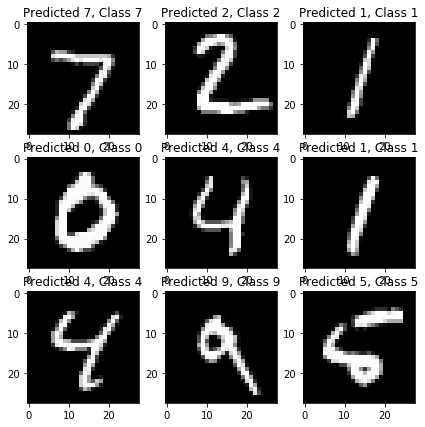

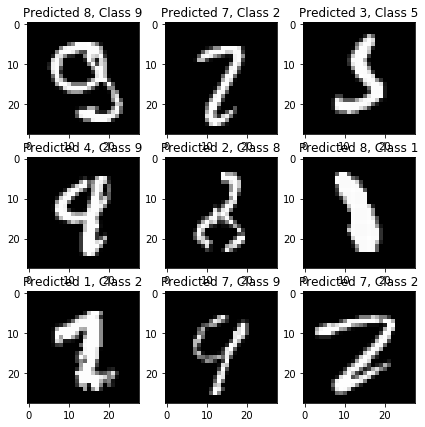

In [38]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test2[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
plt.show()

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test2[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
plt.show()